## This calculates the resolution limit of an image analysis algorithm

For this example we compare 3D-DAOSTORM in single versus multi-emitter fitting mode, but the approach can of course be used to test the performance of any localization algorithm.

Note that the results are not directly comparable with the results of Cohen et al. as among other differences we're using a Gaussian PSF model instead of an Airy PSF model.

References:
* [Cohen et al, Nature Communications, 2019](https://doi.org/10.1038/s41467-019-08689-x).


### Configuring the directory
Create an empty directory somewhere on your computer and tell Python to go to that directory.

In [1]:
import os


### Simulation parameters

These are the parameter values we'll use in the simulation / analysis.

In [ ]:
bg = 10                   # Per pixel background in photons.
camera_gain = 1.0
camera_offset = 100.0
density = 0.017           # Localizations per pixel.
im_size = 512             # Image size in pixels.
iterations = 20
margin = 1
model = "2dfixed"
n_reps = 10               # Number of repeats to average together. 10 or so gives the basic idea
                          # but you need hundreds to get curves as smooth as those in Cohen et al.
pixel_size = 100.0        # Pixel size in nanometers.
roi_size = 10             # Localization ROI in pixels.
sigma = 1.5               # Localization sigma in pixels.
signal = 1000             # Localization intensity in photons.
threshold = 6.0


### Create localizations

In [ ]:
import numpy
import storm_analysis.sa_library.sa_h5py as saH5Py

def emittersUniformRandom():
    # Calculate the size of area covered by the localizations.
    size_x = im_size - 2*margin
    size_y = im_size - 2*margin

    # Calculate number of localizations.
    n_locs = int(round(size_x*size_y*density))

    # Create localizations.
    peaks = {}
    peaks["sum"] = signal * numpy.ones(n_locs)
    peaks["x"] = margin + size_x * numpy.random.uniform(size = n_locs)
    peaks["y"] = margin + size_y * numpy.random.uniform(size = n_locs)
    peaks["z"] = numpy.zeros(n_locs)
    peaks["xsigma"] = sigma*numpy.ones(n_locs)
    peaks["ysigma"] = sigma*numpy.ones(n_locs)
    
    return peaks
    
with saH5Py.SAH5Py("sim_locs.hdf5", is_existing = False, overwrite = True) as h5:
    h5.setMovieInformation(im_size, im_size, n_reps, "")
    for i in range(n_reps):
        locs = emittersUniformRandom()
        h5.addLocalizations(locs, i)
        

### Create movie to analyze

In [ ]:
import storm_analysis.simulator.background as background
import storm_analysis.simulator.camera as camera
import storm_analysis.simulator.emitters_uniform_random as emittersUniformRandom
import storm_analysis.simulator.photophysics as photophysics
import storm_analysis.simulator.psf as psf
import storm_analysis.simulator.simulate as simulate

bg_f = lambda s, x, y, i3 : background.UniformBackground(s, x, y, i3, photons = bg)
cam_f = lambda s, x, y, i3 : camera.Ideal(s, x, y, i3, camera_offset)
pp_f = lambda s, x, y, i3 : photophysics.Duplicate(s, x, y, i3, "sim_locs.hdf5")
psf_f = lambda s, x, y, i3 : psf.GaussianPSF(s, x, y, i3, pixel_size)

sim = simulate.Simulate(background_factory = bg_f,
                        camera_factory = cam_f,
                        photophysics_factory = pp_f,
                        psf_factory = psf_f,
                        x_size = im_size,
                        y_size = im_size)
    
sim.simulate("test.tif", "sim_locs.hdf5", n_reps)
    

### Analyze the movie

First analyze in single fitter mode.

In [ ]:
import storm_analysis.sa_library.parameters as parameters
import storm_analysis.daostorm_3d.mufit_analysis as mfit

def createParametersFile(filename):
    """
    Create a 3D-DAOSTORM parameters file.
    """
    params = parameters.ParametersDAO()

    params.changeAttr("background_sigma", 8.0)

    params.changeAttr("camera_gain", camera_gain)
    params.changeAttr("camera_offset", camera_offset)

    # Since this parameter can be either a float or an int we need
    # to specify which type we want it to be.
    params.changeAttr("find_max_radius", 3, node_type = "float")

    params.changeAttr("foreground_sigma", 1.0)
    params.changeAttr("iterations", iterations)
    params.changeAttr("model", model)
    params.changeAttr("pixel_size", pixel_size)
    params.changeAttr("roi_size", roi_size)
    params.changeAttr("sigma", sigma)
    params.changeAttr("threshold", threshold)

    # Don't do tracking.
    params.changeAttr("radius", "0.0")
    params.changeAttr("descriptor", "1")

    # Don't do drift-correction.
    params.changeAttr("drift_correction", 0)

    # Don't do z fitting.
    params.changeAttr("do_zfit", 0)

    params.toXMLFile(filename, pretty = True)
    

In [14]:
# Only do a single pass of peak finding.
iterations = 1

# Create an XML file with the current parameters.
createParametersFile("single_em.xml")

# Analyze the movie.
if os.path.exists("test_se.hdf5"):
    os.remove("test_se.hdf5")
    
mfit.analyze("test.tif", "test_se.hdf5", "single_em.xml")
    


version 2020.07.01

Peak finding
 Removing values < 1.0 in frame 0
Frame: 0 2503 2503
 Removing values < 1.0 in frame 1
Frame: 1 2546 5049
 Removing values < 1.0 in frame 2
Frame: 2 2542 7591
 Removing values < 1.0 in frame 3
Frame: 3 2556 10147
 Removing values < 1.0 in frame 4
Frame: 4 2572 12719
 Removing values < 1.0 in frame 5
Frame: 5 2478 15197
 Removing values < 1.0 in frame 6
Frame: 6 2518 17715
 Removing values < 1.0 in frame 7
Frame: 7 2565 20280
 Removing values < 1.0 in frame 8
Frame: 8 2527 22807
 Removing values < 1.0 in frame 9
Frame: 9 2578 25385

Added 25385
   10 peak finding iterations.

   0 fits reset due to Cholesky failure.
   3 fits reset due to image margin.
   0 fits reset due to negative value in fit function.
   0 fits reset due to negative height.
   66042 fits reset due to non-decreasing error (LM).
   1 fits did not converge.
   3 fits were lost.
   0 peaks lost to proximity filter.
   0 peaks lost to low significance.
   385147 fitting iterations.

Tra

Repeat analysis in multi-fitter mode.

In [15]:
# Multiples passes of peak finding.
iterations = 20

# Create an XML file with the current parameters.
createParametersFile("multi_em.xml")

# Analyze the movie.
if os.path.exists("test_me.hdf5"):
    os.remove("test_me.hdf5")
    
mfit.analyze("test.tif", "test_me.hdf5", "multi_em.xml")
    


version 2020.07.01

Peak finding
 Removing values < 1.0 in frame 0
Frame: 0 4175 4175
 Removing values < 1.0 in frame 1
Frame: 1 4184 8359
 Removing values < 1.0 in frame 2
Frame: 2 4170 12529
 Removing values < 1.0 in frame 3
Frame: 3 4208 16737
 Removing values < 1.0 in frame 4
Frame: 4 4200 20937
 Removing values < 1.0 in frame 5
Frame: 5 4118 25055
 Removing values < 1.0 in frame 6
Frame: 6 4228 29283
 Removing values < 1.0 in frame 7
Frame: 7 4160 33443
 Removing values < 1.0 in frame 8
Frame: 8 4174 37617
 Removing values < 1.0 in frame 9
Frame: 9 4177 41794

Added 41794
   63 peak finding iterations.

   0 fits reset due to Cholesky failure.
   321 fits reset due to image margin.
   113 fits reset due to negative value in fit function.
   60 fits reset due to negative height.
   269007 fits reset due to non-decreasing error (LM).
   2 fits did not converge.
   189 fits were lost.
   1770 peaks lost to proximity filter.
   678 peaks lost to low significance.
   2544951 fitting i

### Calculate pairwise correlation function.

In [16]:
import scipy
import scipy.spatial


# Average PCF calculation for a movie.
def AveragePCF(h5_name):
    cnts = 0
    r = None
    pcf = None
    with saH5Py.SAH5Reader(h5_name) as h5:
        for [fnum, locs] in h5.localizationsIterator(fields = ["x", "y"]):
            if((fnum%2)==0):
                print("Calculating PCF for", fnum)
            [r, tmp] = PCF(locs)
            if pcf is None:
                pcf = tmp
            else:
                pcf += tmp
            cnts += 1.0
    print()
    pcf = pcf/cnts
    return [r, pcf]
    
    
# PCF function calculation.
def PCF(locs):
    
    # Maximum distance for PCF calculation, this should be an integer.
    max_dist = 30  

    # Create a KDTree to make this more efficient.
    kd = scipy.spatial.KDTree(numpy.stack((locs["x"], locs["y"]), axis = -1))
    
    # Ignore localizations near the edges.
    sx = max_dist + 2
    ex = im_size - max_dist - 3
    mask = (locs["x"] > sx) & (locs["x"] < ex) & (locs["y"] > sx) & (locs["y"] < ex)
    
    n_bins = 10*max_dist
    d_hist = numpy.zeros(n_bins)
    for i in range(mask.size):

        # Skip localizations that are near the edge.
        if not(mask[i]):
            continue
            
        pnt = numpy.array([locs["x"][i], locs["y"][i]])
        [dist, index] = kd.query(pnt, k = None, distance_upper_bound = max_dist)
        [hist, edges] = numpy.histogram(dist, bins = n_bins, range = (0, max_dist), density = False)
        d_hist += hist
        
    # Normalize.
    r = 2.0*numpy.pi*numpy.arange(0.0,max_dist,0.1)*0.1
    d_hist = d_hist/numpy.count_nonzero(mask)
    d_hist = d_hist[1:]/r[1:]
    
    density = numpy.count_nonzero(mask)/((ex-sx)*(ex-sx))
    d_hist = d_hist/density
    
    # r in microns.
    r = r * 1.0e-3 * pixel_size
    
    return [r[1:], d_hist]



In [17]:
# Ground truth PCF.
[r, gt_pcf] = AveragePCF("test_ref.hdf5")

Calculating PCF for 0
Calculating PCF for 2
Calculating PCF for 4
Calculating PCF for 6
Calculating PCF for 8



In [18]:
# Single fitter PCF. 
[r, se_pcf] = AveragePCF("test_se.hdf5")

Calculating PCF for 0
Calculating PCF for 2
Calculating PCF for 4
Calculating PCF for 6
Calculating PCF for 8



In [19]:
# Multi fitter PCF. 
[r, me_pcf] = AveragePCF("test_me.hdf5")

Calculating PCF for 0
Calculating PCF for 2
Calculating PCF for 4
Calculating PCF for 6
Calculating PCF for 8



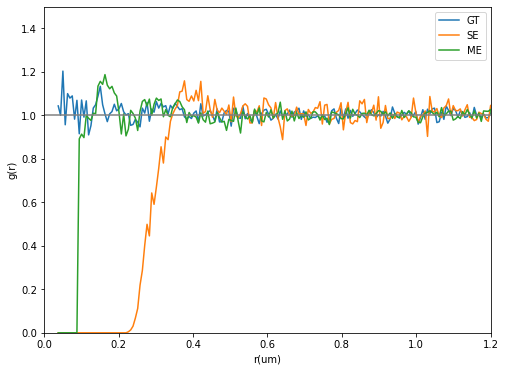

In [20]:
import matplotlib
import matplotlib.pyplot as pyplot

start = 5
pyplot.figure(figsize = (8,6))
pyplot.plot(r[start:], gt_pcf[start:], label = "GT")
pyplot.plot(r[start:], se_pcf[start:], label = "SE")
pyplot.plot(r[start:], me_pcf[start:], label = "ME")
pyplot.plot([-0.1,1.3],[1.0,1.0], color = "gray")
pyplot.legend()
pyplot.xlabel("r(um)")
pyplot.ylabel("g(r)")
pyplot.xlim(0,1.2)
pyplot.ylim(0,1.5)
pyplot.show()